In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from scipy.interpolate import interp1d

from Tablas_mortalidad import *
from finanzas import *
import warnings
import scipy.stats as stats
warnings.filterwarnings('ignore')

In [78]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [79]:
ruta=r'/content/datos_longevidad.xlsx'
data=pd.read_excel(ruta,'Data')
print(data.columns)
data=data[['Edad', 'Casado', 'Genero','Edad_pareja', 'Sexo_pareja', 'Pago_mensual']]
data.head()


Index(['Unnamed: 0', 'Edad', 'Casado', 'Genero', 'Edad_pareja', 'Sexo_pareja',
       'Pago_mensual'],
      dtype='object')


,Edad,Casado,Genero,Edad_pareja,Sexo_pareja,Pago_mensual
0,68,0,M,0,0,4196583.06
1,67,1,H,67,H,1983941.40
2,80,1,H,77,H,4014628.81
3,71,1,H,85,M,5710179.97
4,66,0,M,0,0,7882172.76


In [80]:
##Finanzas - Interes Compuesto

def vf_cte(pago, n, i):

#Pago -> Valor de la mensualidad
#n -> Número de periodos
#i -> Interes de la periodicidad n

  pagos = np.ones(n) * pago
  print(pagos.sum())
  cao_factor = np.ones(n) * (1 + i) ** np.arange(n,0,-1)
  resp_vector = pagos * cao_factor
  resp = resp_vector.sum()
  return resp

In [81]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

def TMensual(Tmort):
    """
    Interpola los valores de l(x) en pasos de 1/12 (mensual) y calcula q(x) y p(x).

    Parameters:
    Tmort (DataFrame): DataFrame que contiene las columnas 'x' y 'l(x)'.

    Returns:
    DataFrame: DataFrame con valores interpolados de x, l(x), q(x) y p(x).
    """

    # Aseguramos que Tmort tiene las columnas adecuadas
    if 'x' not in Tmort.columns or 'l(x)' not in Tmort.columns:
        raise ValueError("El DataFrame debe contener las columnas 'x' y 'l(x)'")

    # Obtener los valores de x y l(x)
    x_values = Tmort['x'].values
    lx_values = Tmort['l(x)'].values

    # Crear una función de interpolación
    interp_function = interp1d(x_values, lx_values, kind='linear', fill_value='extrapolate')

    # Crear los nuevos valores de x con un paso de 1/12, hasta 110 (incluyendo 110)
    new_x = np.arange(x_values[0], 110 + 1/12, 1/12)  # Incrementos mensuales hasta 110

    # Calcular los valores de l(x) interpolados
    new_lx = interp_function(new_x)

    # Inicializar los arrays para q(x) y p(x)
    qx_values = np.zeros(len(new_x) - 1)  # Inicializar el array para q(x)
    px_values = np.zeros(len(new_x) - 1)  # Inicializar el array para p(x)

    # Calcular q(x) y p(x) para cada nuevo valor de x
    for i in range(len(new_x)-1):
        if new_lx[i] > 0:  # Evitar división por cero
            qx_values[i] = 1 - (new_lx[i + 1] / new_lx[i])  # q(x) = 1 - l(x + 1/12) / l(x)
        else:
            qx_values[i] = 0  # Si l(x) es 0, q(x) también debe ser 0

        px_values[i] = 1 - qx_values[i]  # p(x) = 1 - q(x)


    # Crear un nuevo DataFrame con los valores interpolados y calculados
    interpolated_df = pd.DataFrame({
        'x': new_x,  # Incluir hasta 110
        'l(x)': new_lx,  # Excluir el último por la misma razón
        'q(x)': np.append(qx_values, 1),  # Añadir el valor de q(110)
        'p(x)': np.append(px_values, 0)  # Añadir el valor de p(110)
    })

    return interpolated_df

def tmort_filtered(df,edad):
    qx_vec=df[df['x']>=edad]
    return qx_vec

In [82]:
Tmort_h = pd.read_excel('/content/TM_hombres.xlsx')
Tmort_m= pd.read_excel('/content/TM_mujeres.xlsx')
T_hombre=TMensual(Tmort_h)
T_mujer=TMensual(Tmort_m)

In [83]:
valoracion_jubilado = []
valoracion_pareja = []
i = 0.04 / 12

for index, row in data.iterrows():
    genero = row['Genero']
    if genero == 'H':
        tmort = T_hombre
    else:
        tmort = T_mujer

    if row['Casado'] == 0:
        # Renta Vitalicia
        edad = row['Edad']
        pago = row['Pago_mensual']
        T = tmort_filtered(tmort, edad)
        T['n'] = T['x'].apply(lambda x: x - edad) * 12
        T['Vn'] = np.ones(len(T)) * (1 / (1 + i))
        T['Vn'] = T.apply(lambda row: row['Vn'] ** row['n'], axis=1)
        sum_vect = pago * T['Vn'] * T['p(x)']
        va_jubilado = sum_vect.sum()
        va_pareja = 0
        valoracion_jubilado.append(va_jubilado)
        valoracion_pareja.append(va_pareja)

    elif row['Casado'] == 1:
        # Renta Vitalicia Reversible
        edad = row['Edad']
        pago = row['Pago_mensual']
        T = tmort_filtered(tmort, edad)
        T['n'] = T['x'].apply(lambda x: x - edad) * 12
        T['Vn'] = np.ones(len(T)) * (1 / (1 + i))
        T['Vn'] = T.apply(lambda row: row['Vn'] ** row['n'], axis=1)
        sum_vect = pago * T['Vn'] * T['p(x)']
        va_jubilado = sum_vect.sum()

        edad_pareja = row['Edad_pareja']
        genero_pareja = row['Sexo_pareja']
        if genero_pareja == 'H':
            tmort_pareja = T_hombre
        else:
            tmort_pareja = T_mujer

        T_par = tmort_filtered(tmort_pareja, edad_pareja)
        T_par['n'] = T_par['x'].apply(lambda x: x - edad_pareja) * 12
        T_par['Vn'] = np.ones(len(T_par)) * (1 / (1 + i))
        T_par['Vn'] = T_par.apply(lambda row: row['Vn'] ** row['n'], axis=1)

        if edad <= edad_pareja:
            T_par['q(x)_Jub'] = T['q(x)'][:len(T_par)]
        else:
            lista = []
            gap = (edad - edad_pareja) * 12
            lista = list(T['q(x)']) + list(np.ones(gap))
            T_par['q(x)_Jub'] = lista

        sum_vect_pareja = pago * T_par['Vn'] * T_par['p(x)'] * T_par['q(x)_Jub']
        va_pareja = sum_vect_pareja.sum()

        valoracion_jubilado.append(va_jubilado)
        valoracion_pareja.append(va_pareja)

data['Valoracion Jubilado'] = valoracion_jubilado
data['valoracion pareja'] = valoracion_pareja
data['Pago_mensual'] = data['Pago_mensual'].apply(lambda x: f'{x:,.2f}')
data['Valoracion'] = data['Valoracion Jubilado'] + data['valoracion pareja']

In [84]:
data.head()

,Edad,Casado,Genero,Edad_pareja,Sexo_pareja,Pago_mensual,Valoracion Jubilado,valoracion pareja,Valoracion
0,68,0,M,0,0,"4,196,583.06",1017456036.16,0.00,1017456036.16
1,67,1,H,67,H,"1,983,941.40",484784234.22,4985840.73,489770074.95
2,80,1,H,77,H,"4,014,628.81",828188996.93,53608562.26,881797559.19
3,71,1,H,85,M,"5,710,179.97",1339739654.76,6941368.13,1346681022.89
4,66,0,M,0,0,"7,882,172.76",1946327113.36,0.00,1946327113.36


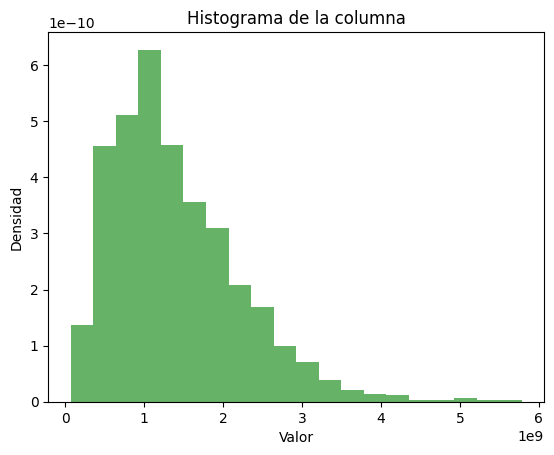

In [85]:
plt.hist(data['Valoracion'],  bins=20, density=True, alpha=0.6, color='g')
plt.title('Histograma de la columna')
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.show()

In [86]:
#Ajustar la distribución gamma a los datos
shape, loc, scale=stats.gamma.fit(data['Valoracion'])

In [87]:
shape

np.float64(2.865752561174397)

In [88]:
scale

np.float64(479640997.50117457)

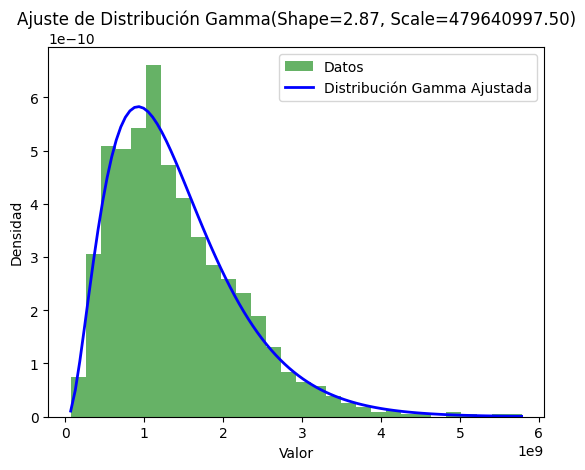

In [89]:
#Crear un rango de valores para la gráfica
x=np.linspace(min(data['Valoracion']),max(data['Valoracion']),100)

#Obtener la funcion de densidad ajustada usando los parametros obtenidos
pdf_gamma_ajustada= stats.gamma.pdf(x,shape,loc,scale)

#Graficar los datos y la funcion de densidad ajustada
plt.hist(data['Valoracion'], bins=30, density=True, alpha=0.6, color='g', label='Datos')

#Graficar la distribución gamma ajustada
plt.plot(x,pdf_gamma_ajustada,'b-',linewidth=2,label='Distribución Gamma Ajustada')

#Mostrar la gráfica
plt.title(f"Ajuste de Distribución Gamma(Shape={shape:.2f}, Scale={scale:.2f})")
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.legend()
plt.show()

In [90]:
#defina el intervalo de confianza de la distribución al 5 %

shape=2.87 #Nuevo parámetro de forma
scale=479640997 #Nuevo parametro de escala

quantile_5=stats.gamma.ppf(0.05,a=shape,scale=scale)
quantile_95=stats.gamma.ppf(0.95,a=shape,scale=scale)

print(f"Cuantil al 5%: {quantile_5}")
print(f"Cuantil al 95%: {quantile_95}")

#¿Que puede concluir de esto?


Cuantil al 5%: 360576647.60582757
Cuantil al 95%: 2926050013.444586


In [ ]:
#Total

In [102]:
###la probabilidad de aceptacion de esta propuesta se comporta como una distribución Binomial de
##parametro P
#Considere que ud cambiará el valor de la renta por un monto hoy, que monto le daria a cada persona?
#Como consultor debe deciir el porcentaje minimo de aceptacióndel colectivo para que el proyecto sea
#visible -> es decir la P min de la binomial.
df_sim = pd.DataFrame()
df_sim['key']=list(data.index)
df_sim['Valoracion']=list(data.Valoracion)
#le daremos a cada persona el 70% del valor de la renta
d=0.7
df_sim['Pago_hoy']=(d)*df_sim['Valoracion']

sim=500
p=0.2 #valor de aceptacion minimo

for i in range(500): #genera 500 simulaciones
  #Genera las muestras de la distribuciónde Binomial
  samples=np.random.binomial(1,p,len(df_sim)) #b(n,p,size)
  df_sim['sim_' + str(i)]=samples

  #Aplica la lógica a cada fila
  #si el valor de la simulación es 1, toma pago hoy; si es 0, toma Valoración
  df_sim['sim_'+ str(i)]=df_sim.apply(
      lambda row: row['Pago_hoy'] if row['sim_' + str(i)]==1 else row['Valoracion'],
      axis=1
  )
